## Import

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import mutual_info_classif, SelectKBest, chi2
from scipy.stats import pearsonr

from pandas.plotting import scatter_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier
import lightgbm as lgb

import numpy as np
from numpy.random import randint
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc
from sklearn.inspection import permutation_importance
import joblib

In [2]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

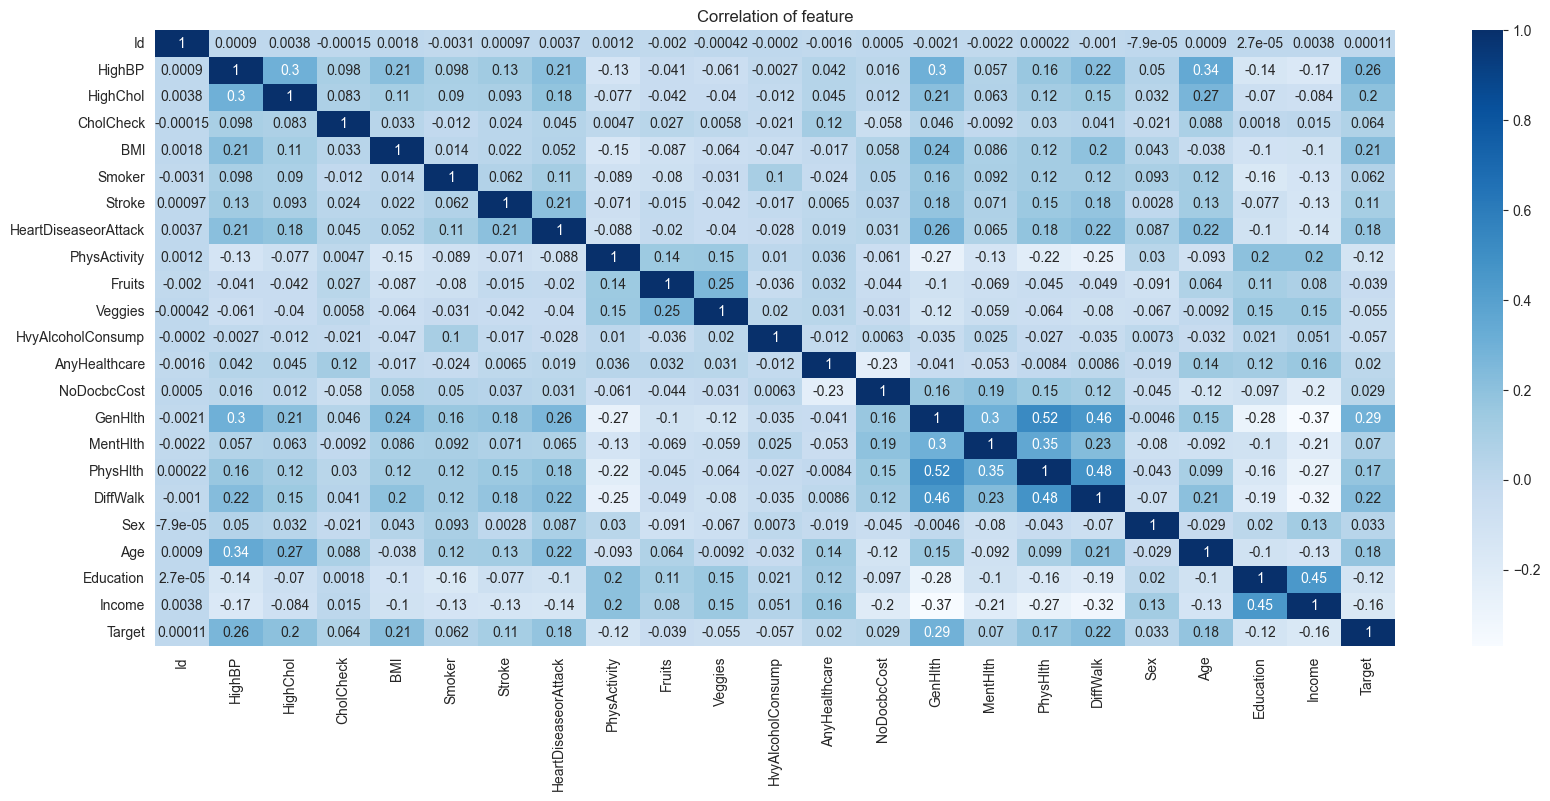

In [3]:
plt.figure(figsize = (20,8))
sns.heatmap(df.corr(), annot=True, cmap='Blues')
plt.title("Correlation of feature")
plt.show()

<Axes: ylabel='Diabetes'>

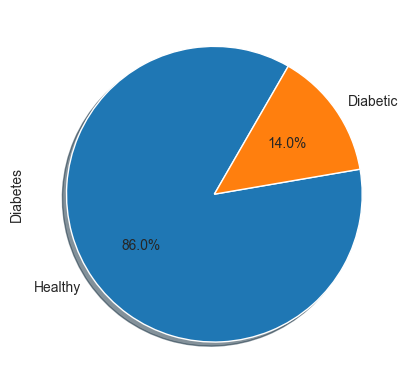

In [37]:
labels = ['Healthy', 'Diabetic']
df.Target.value_counts().plot.pie(labels=labels, autopct='%1.1f%%',shadow=True, startangle=60, ylabel='Diabetes')

In [67]:
X = df.drop(columns=['Target','Id'])
y = df['Target']

# Feature Selection


In [9]:
features = 15

In [10]:
## Mutual Info
mic_features = []
feature_scores = mutual_info_classif(X,y,random_state=27)
for score, name in sorted(zip(feature_scores, X.columns), reverse=True)[:features]:
    mic_features.append(name)
    
print(mic_features)

['GenHlth', 'HighBP', 'PhysActivity', 'AnyHealthcare', 'CholCheck', 'HighChol', 'Veggies', 'BMI', 'Fruits', 'Age', 'DiffWalk', 'Income', 'Smoker', 'Education', 'Sex']


In [29]:
## SelectKBest
skb = SelectKBest(score_func=chi2, k=features)
skb_sel = skb.fit(X,y)
skb_i = skb_sel.get_support()
skb_norm = X.iloc[:,skb_i]
skb_features = list(skb_norm.columns)

print(skb_features)

['HighBP', 'HighChol', 'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'HvyAlcoholConsump', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Age', 'Education', 'Income']


In [91]:
pearson = []
for c in list(X.columns):
    pearson.append(pearsonr(X[c],y))
    
p_v = pd.Series(pearson, index=X.columns)
p_v.sort_values(ascending=False, inplace=True)
pearson_features = list(p_v.index[:features])
print(pearson_features)

['GenHlth', 'HighBP', 'DiffWalk', 'BMI', 'HighChol', 'HeartDiseaseorAttack', 'Age', 'PhysHlth', 'Stroke', 'MentHlth', 'CholCheck', 'Smoker', 'Sex', 'NoDocbcCost', 'AnyHealthcare']


In [92]:
## Selecting the best ones from both
best_all_features = []
for f in skb_features:
    if f in mic_features and f in pearson_features:
        best_all_features.append(f)

print(best_all_features)

['HighBP', 'HighChol', 'BMI', 'Smoker', 'PhysActivity', 'GenHlth', 'DiffWalk', 'Age', 'Education', 'Income', 'HighBP', 'HighChol', 'BMI', 'Smoker', 'PhysActivity', 'GenHlth', 'DiffWalk', 'Age', 'Education', 'Income']


# Splitting the data

In [96]:
selected_features = pearson_features[:10]

X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size=0.3, random_state=27)

# Classifying the data

In [115]:
rf = RandomForestClassifier(
    random_state=27, 
    class_weight='balanced', 
    criterion='entropy',
    n_estimators=400,
    max_depth=14,
    min_samples_split=10,
    min_samples_leaf=4
)

# xgb = (XGBClassifier(
#     scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]), 
#     random_state=27,
#     n_estimators=1,
#     subsample=1.0,
#     min_child_weight=6,
#     max_depth=15,
#     learning_rate=0.3,
#     gamma=0.1,
#     colsample_bytree=0.7,
#     # colsample_bylevel=1,
#     # colsample_bynode=1,
#     # reg_alpha=0,
#     # reg_lambda=1,
# ))

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), list(range(len(selected_features[:10])))),
    ]
)

model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', rf)
])

# # Define parameter grid for XGBClassifier
# param_dist = {
#     'classifier__n_estimators': [100, 200, 300, 500, 700, 1000],
#     'classifier__max_depth': [3, 5, 8, 10, 15, 20, 30],
#     'classifier__learning_rate': [0.01, 0.1, 0.2, 0.3],
#     'classifier__subsample': [0.7, 0.8, 0.9, 1.0],
#     'classifier__colsample_bytree': [0.7, 0.8, 0.9, 1.0],
#     'classifier__gamma': [0, 0.1, 0.2, 0.3],
#     'classifier__min_child_weight': [1, 4, 6, 10]
# }
# 
# random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, 
#                                     n_iter=2, cv=5, n_jobs=-1, scoring='balanced_accuracy', verbose=1, random_state=27)
# random_search.fit(X_train, y_train)
# 
# # Get the best parameters
# best_params = random_search.best_params_
# print(f'Best parameters found: {best_params}')
# 
# # Retrain the model with the best parameters
# best_model = random_search.best_estimator_
# 
# # Evaluate the best model
# predictions = best_model.predict(X_test)
# score = balanced_accuracy_score(y_test, predictions)
# 
# print(f'Balanced Accuracy Score with best parameters: {score}')
# print(classification_report(y_test, predictions))

model.fit(X_train, y_train)

predictions = model.predict(X_test)
val_score = balanced_accuracy_score(y_test, predictions)
print(f"Balanced Accuracy Score on Validation: {val_score}")
print(classification_report(y_test, predictions))

Balanced Accuracy Score on Validation: 0.7181926623929211
              precision    recall  f1-score   support

           0       0.94      0.71      0.81     45847
           1       0.29      0.72      0.41      7426

    accuracy                           0.71     53273
   macro avg       0.62      0.72      0.61     53273
weighted avg       0.85      0.71      0.76     53273



In [105]:
predictions = model.predict(X_test)
val_score = balanced_accuracy_score(y_test, predictions)
print(f"Balanced Accuracy Score on Validation: {val_score}")
print(classification_report(y_test, predictions))

Balanced Accuracy Score on Validation: 0.7046717703447545
              precision    recall  f1-score   support

           0       0.93      0.77      0.84     45847
           1       0.31      0.64      0.42      7426

    accuracy                           0.75     53273
   macro avg       0.62      0.70      0.63     53273
weighted avg       0.84      0.75      0.78     53273

